In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [135]:
plt.rcParams['font.family']=['Heiti TC']
plt.rcParams['figure.figsize']=(20,10)

In [136]:
fn='tutorial/chapter10/demo/data/original_data.xls'
data=pd.read_excel(fn)

In [137]:
data.head()

,热水器编号,发生时间,开关机状态,加热中,保温中,有无水流,实际温度,热水量,水流量,节能模式,加热剩余时间,当前设置温度
0,R_00001,20141019063917,关,关,关,无,30°C,0%,0,关,0分钟,50°C
1,R_00001,20141019070154,关,关,关,无,30°C,0%,0,关,0分钟,50°C
2,R_00001,20141019070156,关,关,关,无,30°C,0%,8,关,0分钟,50°C
3,R_00001,20141019071230,关,关,关,无,30°C,0%,0,关,0分钟,50°C
4,R_00001,20141019071236,关,关,关,无,29°C,0%,0,关,0分钟,50°C


In [138]:
flows=data['有无水流'].value_counts()

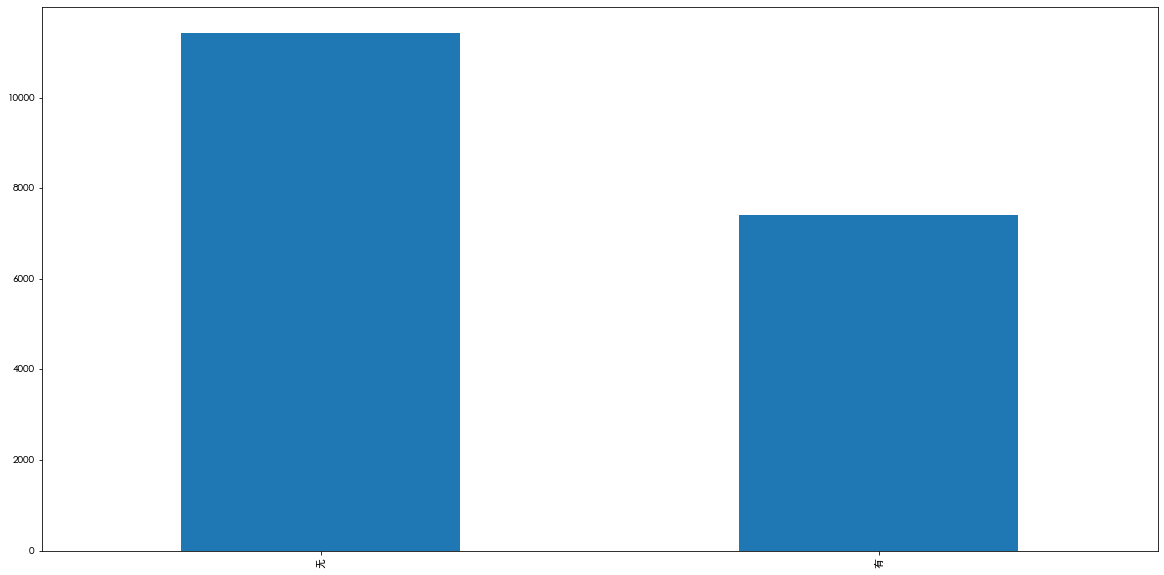

In [139]:
flows.plot.bar()
plt.show()

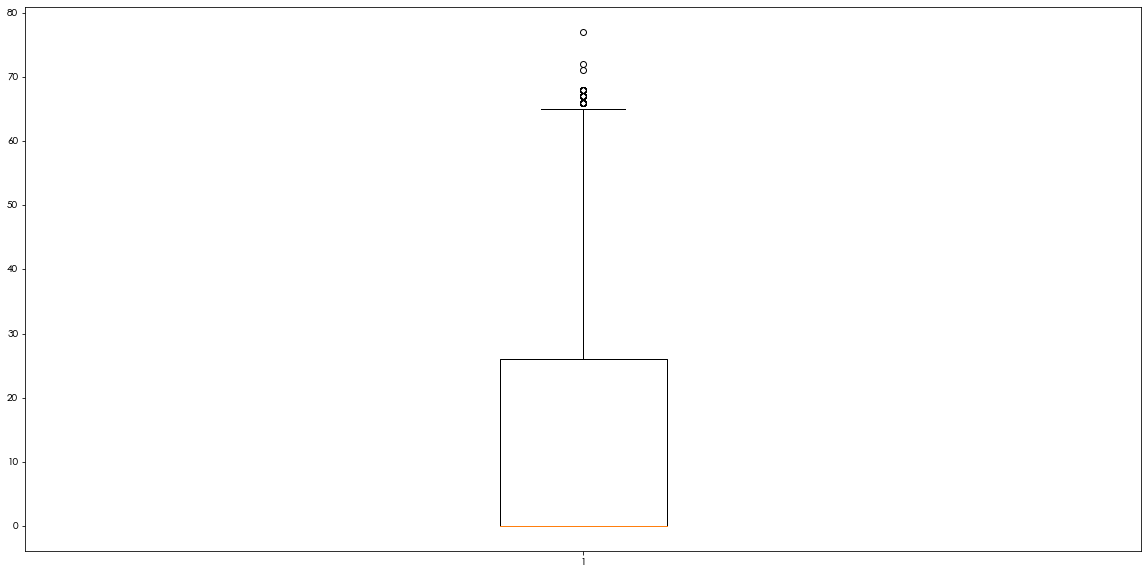

In [140]:
flow_volumes = data['水流量']
plt.boxplot(flow_volumes)
plt.show()

In [141]:
on_states = data[data['水流量'] > 0 ]

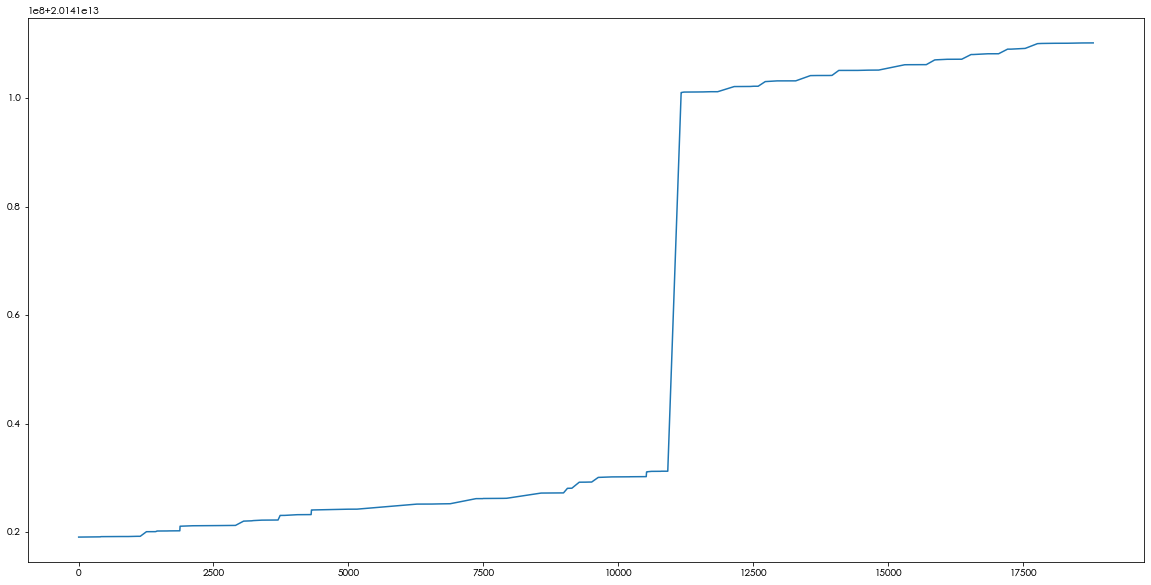

In [142]:
plt.plot(on_states['发生时间'])
plt.show()

In [185]:
fn='tutorial/chapter10/demo/data/original_data.xls'
data=pd.read_excel(fn)

In [186]:
print(len(data),data.shape)

18840 (18840, 12)


In [187]:
data.drop(labels=["热水器编号","有无水流","节能模式"],axis=1,inplace=True) 
print('删除冗余属性后的数据形状为：', data.shape)

删除冗余属性后的数据形状为： (18840, 9)


In [188]:
data.head()

,发生时间,开关机状态,加热中,保温中,实际温度,热水量,水流量,加热剩余时间,当前设置温度
0,20141019063917,关,关,关,30°C,0%,0,0分钟,50°C
1,20141019070154,关,关,关,30°C,0%,0,0分钟,50°C
2,20141019070156,关,关,关,30°C,0%,8,0分钟,50°C
3,20141019071230,关,关,关,30°C,0%,0,0分钟,50°C
4,20141019071236,关,关,关,29°C,0%,0,0分钟,50°C


In [196]:
split_data = data.copy()

In [197]:
split_data['发生时间']=pd.to_datetime(split_data['发生时间'],format='%Y%m%d%H%M%S')

In [225]:
def get_event_num(threshold):
    return sum(split_data['发生时间'].diff() > threshold)+1

In [226]:
split_data = split_data[split_data['水流量'] > 0]

In [227]:
dt = [pd.Timedelta(minutes=i) for i in np.arange(1,9,0.25)]

In [228]:
H = pd.DataFrame(dt,columns=['阈值'])

In [229]:
H['事件数']=H['阈值'].apply(get_event_num)

In [230]:
H['斜率']=H['事件数'].diff()/0.25

In [231]:
H['斜率指标']=H['斜率'].abs().rolling(4).mean()

In [232]:
ts=H['阈值'][H['斜率指标'].idxmin()- 4]

In [233]:
ts

Timedelta('0 days 00:04:00')

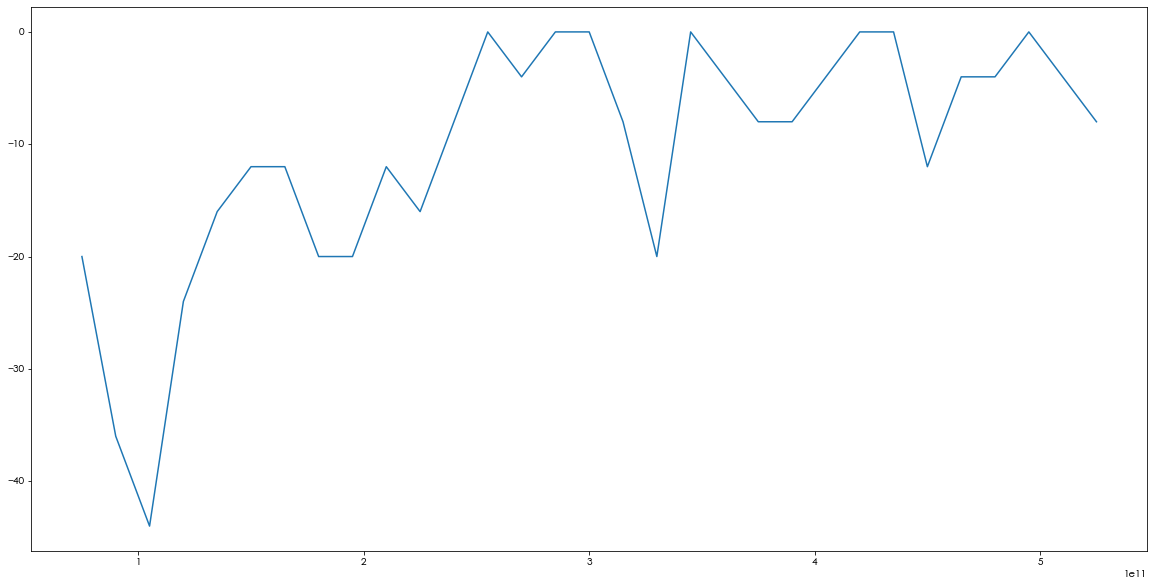

In [234]:
plt.plot(H['阈值'].values,H['斜率'])
plt.show()

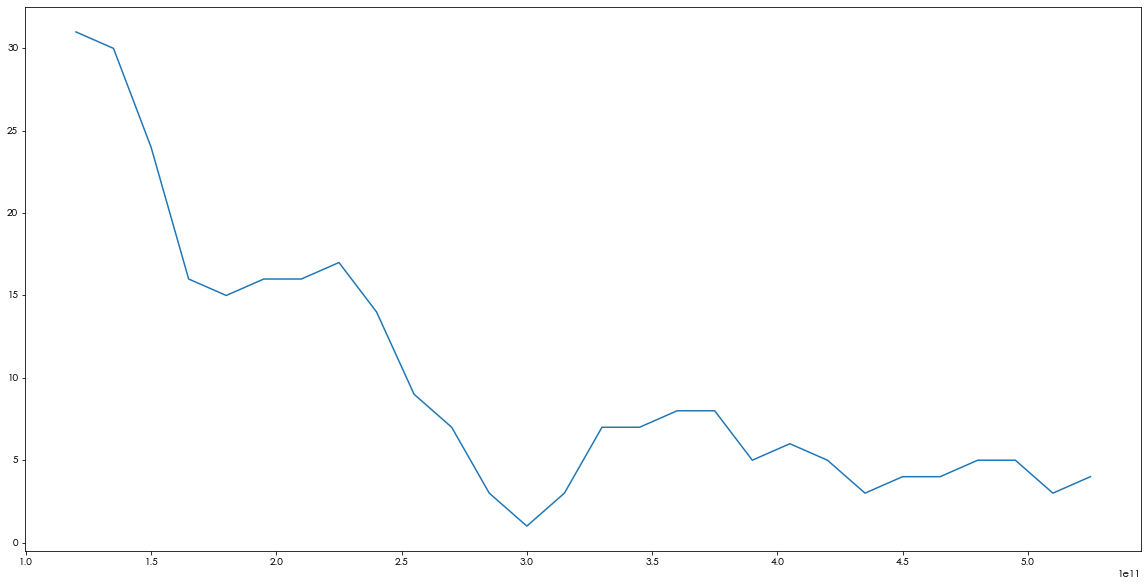

In [235]:
plt.plot(H['阈值'].values,H['斜率指标'])
plt.show()

In [236]:
threshold = pd.Timedelta('4 min')  # 阈值为4分钟
data['发生时间'] = pd.to_datetime(data['发生时间'], format = '%Y%m%d%H%M%S')  # 转换时间格式
data = data[data['水流量'] > 0]  # 只要流量大于0的记录
sjKs = data['发生时间'].diff() > threshold  # 相邻时间向前差分，比较是否大于阈值
sjKs.iloc[0] = True  # 令第一个时间为第一个用水事件的开始事件
sjJs = sjKs.iloc[1:]  # 向后差分的结果
sjJs = pd.concat([sjJs,pd.Series(True)])  # 令最后一个时间作为最后一个用水事件的结束时间
# 创建数据框，并定义用水事件序列
sj = pd.DataFrame(np.arange(1,sum(sjKs)+1),columns = ["事件序号"])
sj["事件起始编号"] = data.index[sjKs == 1]+1  # 定义用水事件的起始编号
sj["事件终止编号"] = data.index[sjJs == 1]+1  # 定义用水事件的终止编号
print('当阈值为4分钟的时候事件数目为：',sj.shape[0])

当阈值为4分钟的时候事件数目为： 172


In [237]:
# data in last cell has been shrink in data = data[data['水流量'] > 0]  # 只要流量大于0的记录
# the sj needs the whole data from the original data
data = pd.read_excel('tutorial/chapter10/demo/data/water_hearter.xlsx')

In [238]:
data["发生时间"] = pd.to_datetime(data["发生时间"],format="%Y%m%d%H%M%S")

# 构造特征：总用水时长
timeDel = pd.Timedelta("0.5 sec")
sj["事件开始时间"] = data.iloc[sj["事件起始编号"]-1,0].values - timeDel
sj["事件结束时间"] = data.iloc[sj["事件终止编号"]-1,0].values + timeDel
sj['洗浴时间点'] = [i.hour for i in sj["事件开始时间"]]
sj["总用水时长"] = np.int64(sj["事件结束时间"] - sj["事件开始时间"])/1000000000 + 1